# Supermarket Data: Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [2]:
df = pd.read_csv('../data/monday.csv', sep=';')
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%d %H:%M:%S")

## Cleaning

* When the shop closes, the remaining customers are rushed through the checkout. Their checkout is not recorded, so it may look as if they stay in the market forever.
* Closing time: 10 p.m. (?)

In [3]:
latest_ts = df['timestamp'].max()
closing_time = latest_ts.replace(hour=22, minute=0, second=0) # https://stackoverflow.com/a/26883852

In [4]:
# TODO ...
closing_time

Timestamp('2019-09-02 22:00:00')

In [5]:
df.head()

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices


## Explore

### Total number of customers in each section.

<AxesSubplot:xlabel='location'>

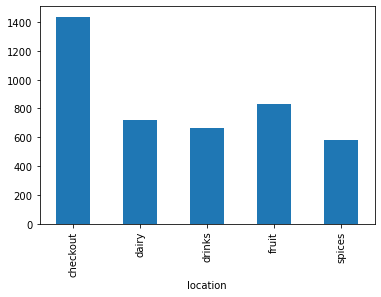

In [6]:
df.groupby('location').nunique()['customer_no'].plot.bar(legend=False)

### Total number of customers in each section over time.

* *Thanks to https://stackoverflow.com/a/48356232*
* see also https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

In [7]:
df.groupby(['location' , pd.Grouper(key='timestamp',freq='H')]).nunique().unstack(fill_value=0)

customer_no                                          \
timestamp 2019-09-02 07:00:00 2019-09-02 08:00:00 2019-09-02 09:00:00   
location                                                                
checkout                   92                 112                  85   
dairy                      52                  59                  42   
drinks                     52                  55                  48   
fruit                      48                  61                  66   
spices                     41                  42                  36   

                                                                       \
timestamp 2019-09-02 10:00:00 2019-09-02 11:00:00 2019-09-02 12:00:00   
location                                                                
checkout                   90                  55                  73   
dairy                      48                  30                  44   
drinks                     30                  19                  30   
fruit                      43                  35                  48   
spices                     41                  22                  33   

                                                                       \
timestamp 2019-09-02 13:00:00 2019-09-02 14:00:00 2019-09-02 15:00:00   
location                                                                
checkout                  120                  90                  94   
dairy                      57                  51                  54   
drinks                     44                  39                  40   
fruit                      75                  53                  64   
spices                     51                  41                  40   

                                                                       \
timestamp 2019-09-02 16:00:00 2019-09-02 17:00:00 2019-09-02 18:00:00   
location                                                                
checkout                   86                 122                 128   
dairy                      42                  66                  73   
drinks                     47                  55                  69   
fruit                      54                  72                  69   
spices                     40                  39                  61   

                                                                       
timestamp 2019-09-02 19:00:00 2019-09-02 20:00:00 2019-09-02 21:00:00  
location                                                               
checkout                  129                 109                  52  
dairy                      53                  54                  20  
drinks                     60                  60                  27  
fruit                      71                  56                  29  
spices                     50                  39                  18

### Display the number of customers at checkout over time.

<AxesSubplot:xlabel='timestamp'>

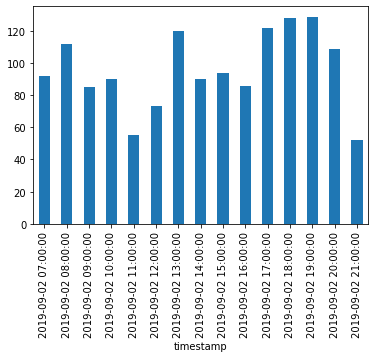

In [8]:
df[ df['location'].eq('checkout') ].groupby(pd.Grouper(key='timestamp',freq='H')).nunique()['customer_no'].plot.bar()

### The time each customer spent in the market.

*See also https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#aggregation*

Text(0.5, 1.0, '')

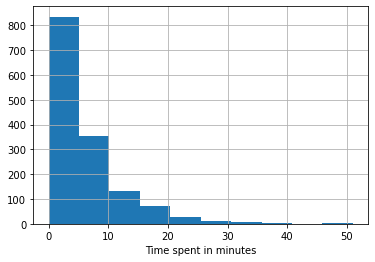

In [9]:
def timedelta_in_minutes(series):
    delta = series.max() - series.min()
    delta_minutes = delta.total_seconds() / 60
    return delta_minutes

df[['timestamp','customer_no']].groupby('customer_no').agg(timedelta_in_minutes).hist()
plt.gca().set_xlabel('Time spent in minutes'); plt.gca().set_title('')

### Total number of customers in the supermarket over time.

<AxesSubplot:xlabel='timestamp'>

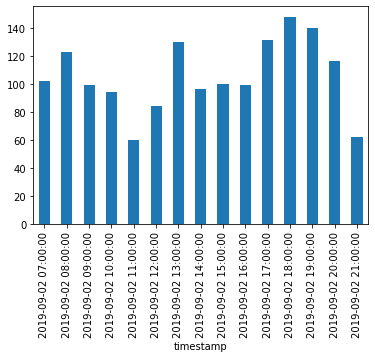

In [10]:
df.groupby(pd.Grouper(key='timestamp',freq='H')).nunique()['customer_no'].plot.bar(legend=False)

### Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

* *https://stackoverflow.com/a/49263586*
* *https://stackoverflow.com/a/55583395*

In [11]:
# assert sorting
df.sort_values(by='timestamp', inplace=True)

In [12]:
df_first = df.groupby('customer_no').first().groupby('location').count()
df_first

,timestamp
location,
dairy,412
drinks,232
fruit,520
spices,283


In [13]:
def tail(df):
    return df[1:]
df_following = df.groupby('customer_no').apply(tail).groupby('location').count()[['timestamp']]
df_following

,timestamp
location,
checkout,1437
dairy,483
drinks,565
fruit,485
spices,467


In [14]:
df_first.rename(mapper={df_first.columns[0]:'first'}, axis=1, inplace=True)
df_following.rename(mapper={df_following.columns[0]:'following'}, axis=1, inplace=True)
df_counts = pd.concat([df_first,df_following],axis=1)

<AxesSubplot:xlabel='location'>

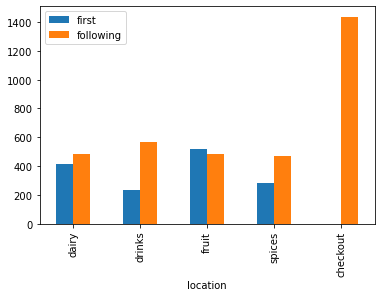

In [15]:
df_counts.plot.bar()

* Nobody starts at checkout which makes sense.
* Significant less people go for drinks or spices at first.